In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('ar_properties_slim.csv', index_col = 'id', low_memory=False)

In [3]:
ars_usd = pd.read_csv('ars-usd.csv')
# source:
# https://www.investing.com/currencies/usd-ars-historical-data

In [4]:
data.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
wdQ5hWhv8P14T7Sh9g4QCg==,Propiedad,12/25/2020,12/31/9999,12/25/2020,-32.716652,-68.642692,Argentina,Mendoza,NaN,NaN,...,NaN,NaN,NaN,350.0,350.0,NaN,NaN,NaN,Lote,Venta
nnMBYZ4RMRY+vm753EtA+g==,Propiedad,12/25/2020,12/31/9999,12/25/2020,-24.797723,-65.467514,Argentina,Salta,NaN,NaN,...,NaN,NaN,NaN,1541.0,1541.0,NaN,NaN,Mensual,Lote,Venta
+dnVA1K6JxzL1zAjOEQ1pA==,Propiedad,12/25/2020,12/29/2020,12/25/2020,-34.919373,-58.020591,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,NaN,NaN,NaN,1000.0,1000.0,NaN,NaN,Mensual,Lote,Venta
dLHXKN5/sRZpm9Yk0yI2nA==,Propiedad,12/25/2020,12/29/2020,12/25/2020,-34.919455,-58.024807,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,NaN,NaN,NaN,1000.0,1000.0,NaN,NaN,Mensual,Lote,Venta
wtw/k887EPipd37UYHKb1Q==,Propiedad,12/25/2020,12/31/9999,12/25/2020,-34.364924,-58.78314257,Argentina,Bs.As. G.B.A. Zona Norte,Escobar,Belén de Escobar,...,NaN,NaN,NaN,18164.0,18164.0,NaN,NaN,Mensual,Otro,Venta


In [5]:
print('initial len(data):',len(data))

# two random non-date strings included in the date attribute columns
# this filter eliminates those without the two forward slashes indicative of a valid date
valid_start_date = np.array([date_string.count('/') == 2 for date_string in data.start_date])
data = data[valid_start_date == True]
print('after cleaning start_date:',len(data))

valid_end_date = np.array([date_string.count('/') == 2 for date_string in data.end_date])
data = data[valid_end_date == True]
print('after cleaning end_date:',len(data))

valid_created_date = np.array([date_string.count('/') == 2 for date_string in data.created_on])
data = data[valid_created_date == True]
print('after cleaning created_on:',len(data))

initial len(data): 1000002
after cleaning start_date: 1000000
after cleaning end_date: 1000000
after cleaning created_on: 1000000


In [6]:
# convert lat/lon to floats instead of strings
data.lat = [float(latitude) for latitude in data.lat]
data.lon = [float(longitude) for longitude in data.lon]

# remove rows with NaN for price since price is what we are predicting
data = data.dropna(subset=['price'])
;
print('after cleaning price:', len(data))

after cleaning price: 963098


In [7]:
# convert timestamps to datetime data type:
def reformat_dates(date_array):
    dates_dict = {}
    formatted_date = []
    for date in date_array:
        if date not in dates_dict:
            if date[-4:] == '9999':
                dates_dict[date] = pd.to_datetime('3/15/2021') # last date in dataset
            else:
                dates_dict[date] = pd.to_datetime(date)
        formatted_date += [dates_dict[date]]
    return formatted_date

data.start_date = reformat_dates(data.start_date)
data.end_date = reformat_dates(data.end_date)
data.created_on = reformat_dates(data.created_on)
ars_usd.date = reformat_dates(ars_usd.date)

In [8]:
# certain numeric columns came in as strings. Convert these to floats:
for feature in ['rooms','bedrooms','bathrooms','surface_total','surface_covered','price']:
    data[feature] = np.array([float(value_string) for value_string in data[feature]])

In [9]:
# price in ARS is volatile relative to USD - converting to USD may make prices more comparable over time
ars_usd_dict = {}
for i in range(len(ars_usd)):
    ars_usd_dict[ars_usd.at[i,'date']] = ars_usd.at[i,'exchange']
    
initial_date = pd.to_datetime('1/7/2019')

# weekends have no official market exchange rate, so we substitute from the last business day
for i in range(1089):
    date = initial_date + datetime.timedelta(i)
    reference_date = date
    while reference_date not in ars_usd_dict:
        reference_date = reference_date - datetime.timedelta(1)
    ars_usd_dict[date] = ars_usd_dict[reference_date]

# now we create a usd price column in the original dataframe
data['ars_usd'] = [ars_usd_dict[date] for date in data.created_on]
data['usd_price'] = data.price / data.ars_usd
;

''

''

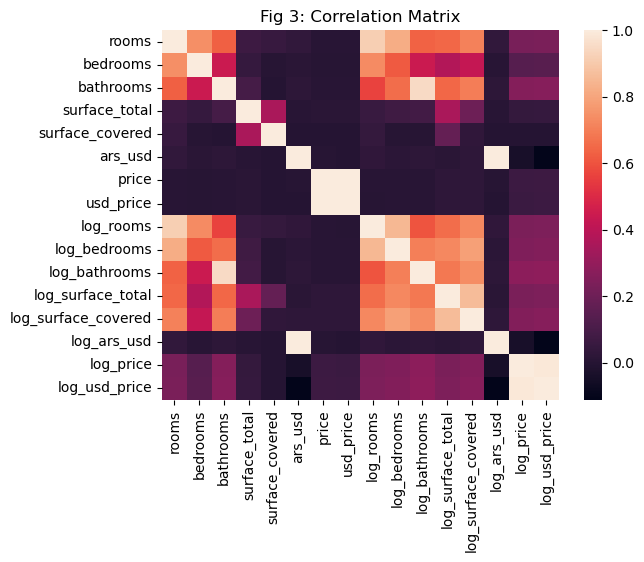

In [38]:
base_features = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'ars_usd', 'price', 'usd_price']
log_features = []
for feature in base_features:
    def adj_log(nums):
        output = []
        for n in nums:
            if n <= 0:
                output += [0]
            else:
                output += [np.log(n)]
        return np.array(output)
    data['log_' + feature] = adj_log(data[feature])
    log_features += ['log_' + feature]

continuous_data = data[base_features + log_features]
correlation_matrix = continuous_data.corr(numeric_only=True)
#print(correlation_matrix)
sns.heatmap(correlation_matrix)
plt.title('Fig 3: Correlation Matrix')
;

''

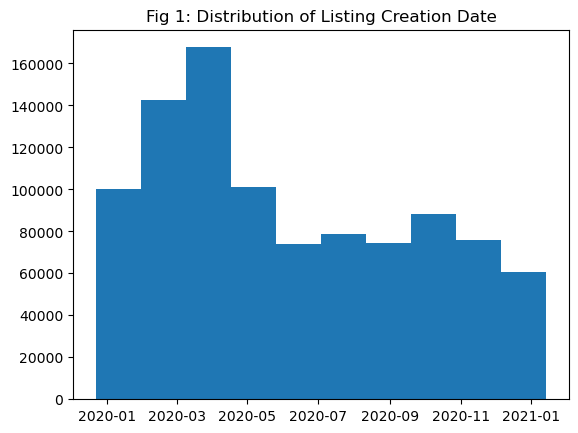

In [36]:
plt.hist(data.created_on)
plt.title('Fig 1: Distribution of Listing Creation Date')
;

''

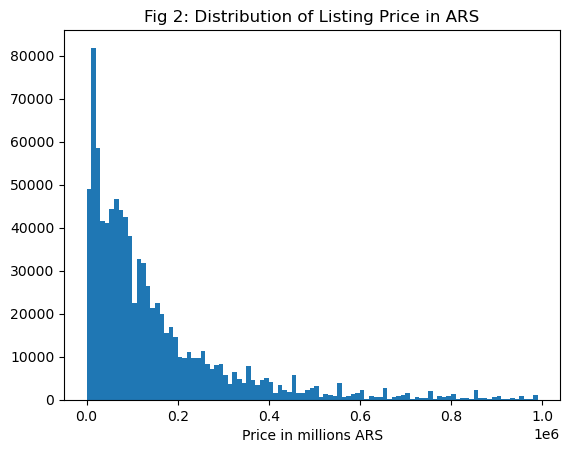

In [37]:
plt.hist(data.price, bins=(np.arange(0,1000000,10000)))
plt.title('Fig 2: Distribution of Listing Price in ARS')
plt.xlabel('Price in millions ARS')
;

In [13]:
'''
ROADMAP
clean data
    remove unneeded columns
    ensure proper data types
        clean dates
    remove erroneous data (ex NaN)
    bring in ARG->USD daily and convert to USD

preliminary correlation matrix for continuous attributes
preliminary regression using continuous attributes to get some basic plots and sense of the landscape
    include feature^2 and log(feature) as well to check for non-linearities

GRAPHS:
correlation matrix
distribution of created_on
distribution of usd_price
exchange rate over time



'''

'\nROADMAP\nclean data\n    remove unneeded columns\n    ensure proper data types\n        clean dates\n    remove erroneous data (ex NaN)\n    bring in ARG->USD daily and convert to USD\n\npreliminary correlation matrix for continuous attributes\npreliminary regression using continuous attributes to get some basic plots and sense of the landscape\n    include feature^2 and log(feature) as well to check for non-linearities\n\n    \n\n\n\n'